In [1]:
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
# import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm
# from scipy.interpolate import interp1d
# import seaborn as sns
# import os
# from scipy.stats import pearsonr, spearmanr
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import pickle
# from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, kendalltau
# from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
# from scipy.stats import skew

# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# from PlottingFunctions import *
from dict_types import *

## Read dataframe of results for all gauges

In [63]:
all_events_all_res = pd.read_csv("../test.csv")
cols_5mins = [col for col in all_events_all_res.columns if '5m' in col]
all_events_5mins = all_events_all_res[cols_5mins]
all_events_5mins.columns = all_events_5mins.columns.str.replace('_5m$', '', regex=True)

### Remove columns we're not interested in (rn)

In [3]:
# del all_events_df['min_intensity']
# del all_events_df['m1'], all_events_df['m2'], all_events_df['m3'], all_events_df['m4'], all_events_df['m5']
# del all_events_df['time_to_peak']
# del all_events_df['BSC_DMC']
# del all_events_df['mean_intensity_DMC']
# del all_events_df['min_intensity_DMC']

In [4]:
# metric_base_names = {col.replace(suffix, '') for col in all_events_df.columns  for suffix in ['_DMC_10']  if col.endswith(suffix)}

In [5]:
# spearmansr_ls = []
# metric_names = []
# suffixes = ['', '_log', '_yj']

# for i, base_name in enumerate(metric_columns):

#         if col1 in scaled_all_events_df.columns and col2 in scaled_all_events_df.columns:
#             x = scaled_all_events_df[col1]
#             y = scaled_all_events_df[col2]
            
#             pearsonsr_ls.append(pearsonr(x, y)[0])
#             spearmansr_ls.append(spearmanr(x, y)[0])
#             metric_names.append(base_name + suffix)
#             found_pair = True
#             break  # stop after finding first matching suffix pair
            
#     if not found_pair:
#         print(f"No matching pair found for metric '{base_name}' with any suffix")

## Create correlation matrix

In [6]:
# spearman_corr = transformed_scaled.corr(method='spearman')
# # Reorder based on absolute total Spearman correlation strength
# spearman_strength = spearman_corr.abs().sum().sort_values(ascending=False)
# ordered_columns = spearman_strength.index.tolist()
# reordered_spearman = spearman_corr.loc[ordered_columns, ordered_columns]

# # Plot Spearman heatmap
# plt.figure(figsize=(20, 15))
# mask = np.triu(np.ones_like(reordered_spearman, dtype=bool))
# sns.heatmap(
#     reordered_spearman, mask=mask, cmap='coolwarm',
#     annot=False, fmt=".2f", linewidths=0.5, cbar=True,
#     xticklabels=True, yticklabels=True, annot_kws={"size": 12}, vmin=-1, vmax=1)

# plt.title("Spearman Rank Correlation Matrix (Ordered by Strength)", fontsize=16)
# plt.tight_layout()
# plt.show()


In [7]:
# correlation_matrix_raw_pearson = transformed_scaled.corr(method = 'pearson')
# # corr_strength = correlation_matrix_raw_pearson.abs().sum().sort_values(ascending=False)

# # Reorder both rows and columns
# # ordered_columns = corr_strength.index.tolist()
# reordered_corr = correlation_matrix_raw.loc[ordered_columns, ordered_columns]

# # Plot
# plt.figure(figsize=(20, 15))
# mask = np.triu(np.ones_like(reordered_corr, dtype=bool))
# sns.heatmap(
#     reordered_corr, mask=mask, cmap='coolwarm',
#     annot=False, fmt=".2f", linewidths=0.5, cbar=True,
#     xticklabels=True, yticklabels=True, annot_kws={"size": 16}, vmin=-1, vmax=1)

# plt.title("Correlation Matrix (Ordered by Total Correlation Strength)", fontsize=16)
# plt.tight_layout()
# plt.show()

In [8]:
# diff_matrix = reordered_spearman - reordered_corr

# plt.figure(figsize=(20, 15))
# mask = np.triu(np.ones_like(diff_matrix, dtype=bool))
# sns.heatmap(
#     diff_matrix, mask=mask, cmap='vlag', center=0,
#     annot=False, fmt=".2f", linewidths=0.5, cbar=True,
#     xticklabels=True, yticklabels=True)

# plt.title("Difference: Spearman - Pearson Correlation", fontsize=16)
# plt.tight_layout()
# plt.show()


## Cluster analysis

In [72]:
del all_events_5mins['T50']
del all_events_5mins['m5']
del all_events_5mins['m4']
del all_events_5mins['m3']
del all_events_5mins['m2_log']
del all_events_5mins['m1_log']
del all_events_5mins['centre_gravity']
del all_events_5mins['BSC_Index_yj']

In [73]:
data_for_clustering = all_events_5mins.T  

In [74]:
names = data_for_clustering.index
names_full = []
# Group by cluster and build the display string
for name in names:
    name = name.replace("_yj", "")
    name = name.replace("_log", "")
    this_name_full =f"{names_lookup[name]}"
    names_full.append(this_name_full)

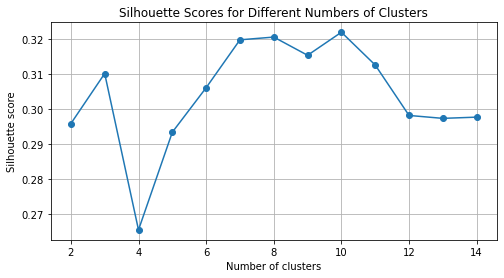

In [75]:
range_n_clusters = list(range(2, 15))
silhouette_scores = []

for n_clusters in range_n_clusters:
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    labels = clusterer.fit_predict(data_for_clustering)
    score = silhouette_score(data_for_clustering, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Scores for Different Numbers of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

In [76]:
names = data_for_clustering.index
names_base = []
names_types = []
# Group by cluster and build the display string
for name in names:
    name = name.replace("_yj", "")
    name = name.replace("_log", "")
    names_base.append(name)
    names_type =f"{name} ({dict_types[name]})"
    names_types.append(names_type)

In [77]:
resolutions = ['10m', '30m', '60m']
resolution_colors = {'10m': '#1f77b4', '30m': '#ff7f0e', '60m': '#2ca02c'}
    
def spaced_colors_from_cmap(cmap_name, values=[0.1, 0.5, 0.9], add_grey=False):
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(v)[:3] for v in values]  # RGB only
    if add_grey:
        grey = (0.6, 0.6, 0.6)  # or (0.5, 0.5, 0.5) for slightly darker grey
        colors = [grey] + colors
    return colors   

# First: Create the mapping for continuous metrics
metric_list = ['frac_q3_wi_yj', 'peak_mean_ratio_log', 'cv_log', 'frac_q1_wi', 'time_kurtosis_log', 'Mean Intensity HIZ',
               '% rain HIZ', 'frac_q2_wi', 'event_dry_ratio', 'lorentz_asymetry', 'm5_wi', 'D50', 'm1_log',
               'Event Loading', 'time_to_peak_yj', 'asymm_d', 'centre_gravity', 'max_intensity_log', 'm3_wi',
               'kurtosis_yj', 'skewp', 'I30_log', 'peak_position_ratio', 'std_log', 'PCI', 'time_skewness', 'm1_wi_log',
               'mean_intensity_log', 'intermittency_yj', 'T75', 'relative_amp_log', 'NRMSE_P_yj', 'm2_wi_log', '% time LIZ',
               'm4_wi', 'T25_log', 'm2_log', 'skewness_yj', '% time HIZ', 'centre_gravity_interpolated', 'frac_q4_wi',
               'gini', 'TCI']

type_2_list = ['Asymmetry', 'Peakiness', 'Peakiness', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Concentration',
               'Asymmetry', 'Intermittency', 'Concentration', 'Asymmetry', 'Asymmetry', 'Asymmetry', 'Asymmetry',
               'Asymmetry', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Asymmetry', 'Peakiness', 'Asymmetry', 'Peakiness',
               'Asymmetry', 'Peakiness', 'Concentration', 'Asymmetry', 'Asymmetry', 'Peakiness', 'Intermittency',
               'Asymmetry', 'Peakiness', 'Concentration', 'Peakiness', 'Concentration', 'Asymmetry', 'Asymmetry',
               'Peakiness', 'Peakiness', 'Concentration', 'Asymmetry', 'Concentration', 'Concentration', 'Concentration']

type_color_map = {
    'Asymmetry': spaced_colors_from_cmap("Blues", add_grey=True),
    'Peakiness': spaced_colors_from_cmap("Reds", add_grey=True),
    'Concentration': spaced_colors_from_cmap("Greens", add_grey=True),
    'Intermittency': spaced_colors_from_cmap("Purples", add_grey=True),
    'Categorical': spaced_colors_from_cmap("Oranges", add_grey=True),}

resolution_index = {'10m': 0, '30m': 1, '60m': 2}

# Map type_2 to metrics
type_2_mapping = dict(zip(metric_list, type_2_list))

# --- Extract all metrics present in transformed_minmax_scaled ---
all_metric_names = names

# --- Assign types ---
metric_type_df = (
    pd.DataFrame({'metric': all_metric_names})
    .assign(type_2=lambda df: df['metric'].map(type_2_mapping)))

metric_type_df.fillna('Categorical', inplace=True)

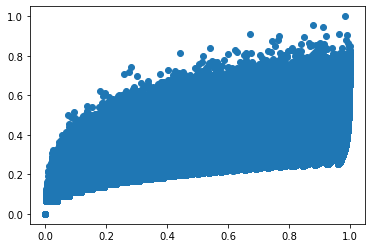

In [83]:
plt.scatter(all_events_5mins['peak_position_ratio'], all_events_5mins['time_to_peak_yj'])


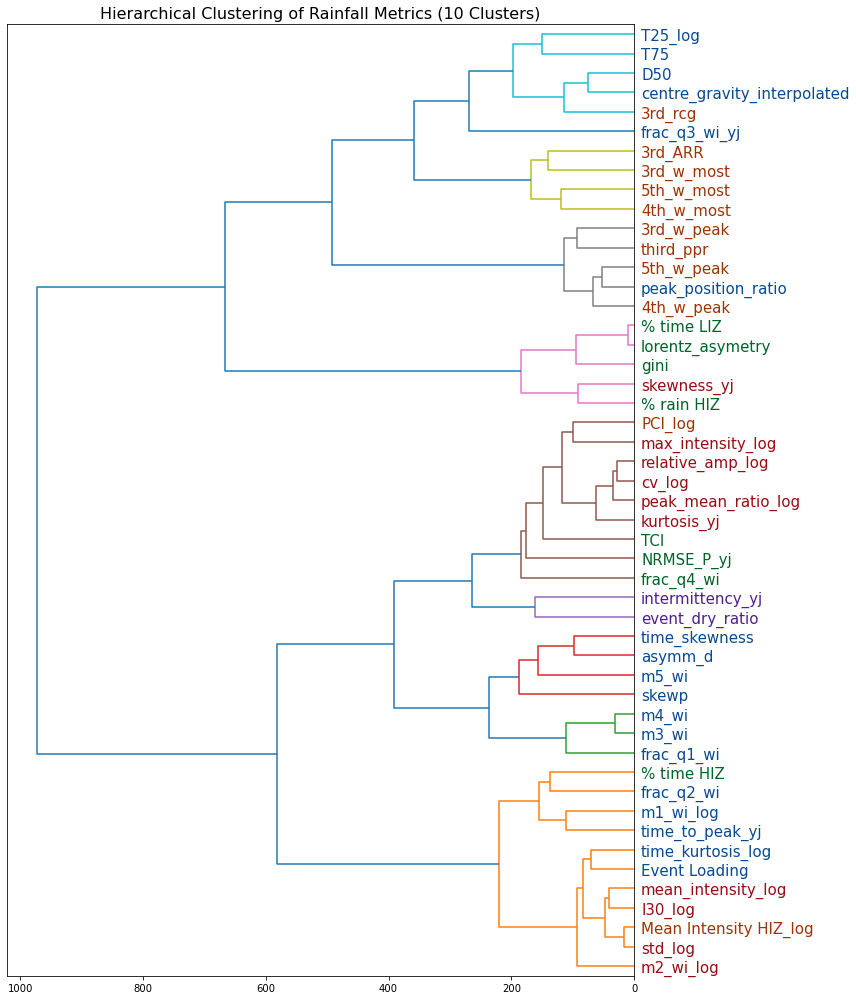

In [79]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

# Build color lookup from metric name → type color
type_lookup = dict(zip(all_metric_names, metric_type_df['type_2']))
label_colors = {
    metric: to_hex(type_color_map[type_lookup[metric]][3])  # or [1] or [2] if needed
    for metric in all_metric_names
}

# Hierarchical clustering
Z = linkage(data_for_clustering, method='ward')
n_clusters = 10
threshold = Z[-(n_clusters - 1), 2]

# Plot dendrogram
fig, ax = plt.subplots(figsize=(12, 14))
ddata = dendrogram(
    Z,
    labels=data_for_clustering.index,
    leaf_rotation=0,
    leaf_font_size=15,
    orientation='left',
    color_threshold=threshold,
    ax=ax
)

# Color the leaf labels
leaf_labels = ax.get_yticklabels()  # yticklabels for 'left' orientation
for label in leaf_labels:
    text = label.get_text()
    if text in label_colors:
        label.set_color(label_colors[text])

# Title, layout
ax.set_title(f'Hierarchical Clustering of Rainfall Metrics ({n_clusters} Clusters)', fontsize=16)
plt.tight_layout()
plt.show()


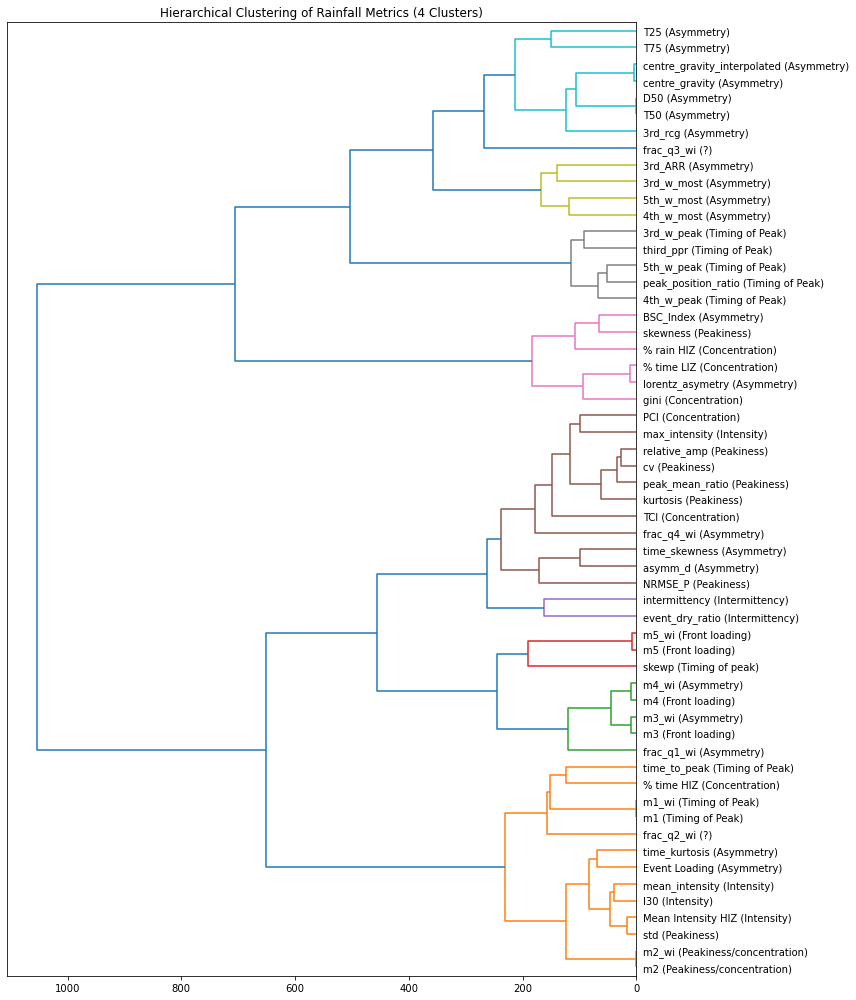

In [15]:
# Hierarchical clustering
Z = linkage(data_for_clustering, method='ward')

# Get cluster labels for 4 clusters
n_clusters = 10
cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')

# Create DataFrame for cluster membership
cluster_df = pd.DataFrame({
    'Metric': data_for_clustering.index,
    'Cluster': cluster_labels
}).set_index('Metric')

# Get color threshold for dendrogram
threshold = Z[-(n_clusters - 1), 2]

# Plot dendrogram with color-coded branches
plt.figure(figsize=(12, 14))
dendrogram(
    Z,
    labels=names_types,
    leaf_rotation=0,
    leaf_font_size=10,
    orientation='left',
    color_threshold=threshold
)
plt.title('Hierarchical Clustering of Rainfall Metrics (4 Clusters)')
plt.tight_layout()
plt.show()

### Kmeans clustering

In [167]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=10, random_state=0, batch_size=10000)
labels = kmeans.fit_predict(data_for_clustering)
# Add labels to your original dataframe for inspection or plotting
data_for_clustering['cluster_label'] = labels
data_for_clustering.index= names_types

In [168]:
# Assuming you already have cluster_df with 'Cluster' as column and metric index
# Sort by cluster to group metrics nicely
cluster_df_sorted = data_for_clustering.sort_values('cluster_label')

# Group metrics by cluster
grouped = cluster_df_sorted.groupby('cluster_label').apply(lambda x: list(x.index))

# Find the max number of metrics in any cluster for row alignment
max_len = max(len(metrics) for metrics in grouped)

# Pad each cluster list with empty strings to equalize length
for cluster in grouped.index:
    metrics = grouped[cluster]
    grouped[cluster] = metrics + [''] * (max_len - len(metrics))

# Convert to DataFrame: columns = clusters, rows = metrics
cluster_table = pd.DataFrame(dict(zip(
    [f'Cluster {c}' for c in grouped.index], 
    [grouped[c] for c in grouped.index])))

cluster_table

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
0,intermittency (Intermittency),time_kurtosis (Asymmetry),5th_w_peak (Asymmetry),PCI (Concentration),skewp (Timing of peak),centre_gravity (Asymmetry),peak_mean_ratio_scaled (Peakiness),peak_position_ratio (Timing of Peak),gini (Concentration),3rd_ARR (Asymmetry)
1,event_dry_ratio (Intermittency),frac_q2_wi_ (?),T75 (Asymmetry),time_skewness (Asymmetry),m3_wi (Asymmetry),T50 (Asymmetry),ni (Peakiness),third_ppr (Timing of peak),lorentz_asymetry (Asymmetry),
2,,m2_wi (Peakiness),4th_w_peak (Asymmetry),asymm_d (Asymmetry),frac_q1_wi_ (Asymmetry),centre_gravity_interpolated (Asymmetry),TCI (Concentration),,BSC_Index (Asymmetry),
3,,m1_wi (Timing of Peak),3rd_w_peak (Asymmetry),skewness (Peakiness),m4_wi (Asymmetry),3rd_rcg (Asymmetry),kurtosis (Peakiness),,% rain HIZ (Concentration),
4,,Mean Intensity HIZ (Intensity),,NRMSE_P (Peakiness),m5_wi (Asymmetry),T25 (Asymmetry),relative_amp (Peakiness),,% time LIZ (Concentration),
5,,std (Peakiness),,,,D50 (Asymmetry),cv (Peakiness),,,
6,,mean_intensity (Intensity),,,,,frac_q4_wi_ (Asymmetry),,,
7,,% time HIZ (Concentration),,,,,peak_mean_ratio (Peakiness),,,
8,,I30 (Intensity),,,,,,,,
9,,max_intensity (Intensity),,,,,,,,


## PCA

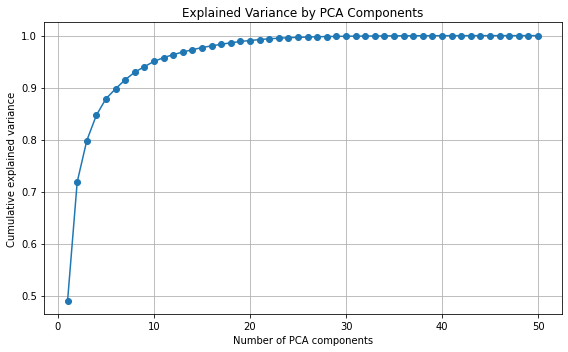

In [173]:
# Assuming all_events_df is already scaled
pca = PCA()
metrics_df = transformed_scaled.T
pca.fit(metrics_df)

explained_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.xlabel("Number of PCA components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.tight_layout()
plt.show()

n_clusters = 2, silhouette score = 0.3883
n_clusters = 3, silhouette score = 0.3599
n_clusters = 4, silhouette score = 0.3916
n_clusters = 5, silhouette score = 0.4024
n_clusters = 6, silhouette score = 0.4311
n_clusters = 7, silhouette score = 0.4400
n_clusters = 8, silhouette score = 0.4355
n_clusters = 9, silhouette score = 0.4284
n_clusters = 10, silhouette score = 0.4161


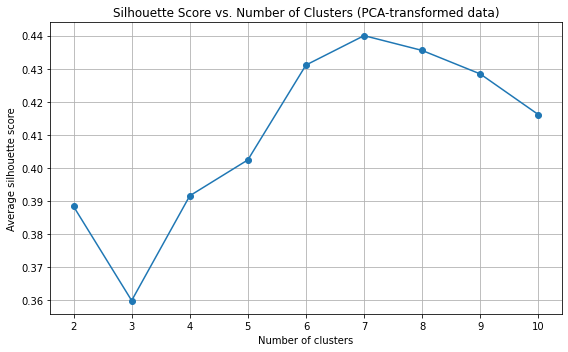

In [174]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Apply PCA
pca = PCA(n_components=4)  # Use enough components to retain >80-90% variance
X_pca = pca.fit_transform(metrics_df)

# 2. Try multiple cluster counts and calculate silhouette scores
range_n_clusters = range(2, 11)
silhouette_scores = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"n_clusters = {n_clusters}, silhouette score = {silhouette_avg:.4f}")

# 3. Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. Number of Clusters (PCA-transformed data)")
plt.xlabel("Number of clusters")
plt.ylabel("Average silhouette score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [178]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting
import seaborn as sns
import pandas as pd

# Transpose so each row is a metric
metrics_df = transformed_scaled.T

# Apply PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(metrics_df)

# Create PCA DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=metrics_df.index)

# KMeans clustering
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
pca_df['cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# # Stronger color map
# colors = sns.color_palette("Set1", n_colors=n_clusters)

# # 3D plot
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(111, projection='3d')

# for i, row in pca_df.iterrows():
#     ax.scatter(row['PC1'], row['PC2'], row['PC3'], 
#               color=colors[int(row['cluster'])], s=60, edgecolor='k')
#     ax.text(row['PC1'], row['PC2'], row['PC3'], i, fontsize=8, color='black')

# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_zlabel("PC3")
# plt.title("3D PCA Projection of Metrics with Cluster Labels")
# plt.tight_layout()
# plt.show()


In [179]:
# Group metrics by cluster label
for cluster_id in sorted(pca_df['cluster'].unique()):
    print(f"\nCluster {cluster_id}:")
    print(", ".join(pca_df[pca_df['cluster'] == cluster_id].index))


Cluster 0:
event_dry_ratio, time_skewness, skewness_yj, NRMSE_P_yj

Cluster 1:
max_intensity_log, frac_q3_wi_, Event Loading, I30_log, mean_intensity_log, std_log, Mean Intensity HIZ_log, m1_wi_log, m2_wi_log, frac_q2_wi_, time_kurtosis_log

Cluster 2:
peak_position_ratio, 3rd_rcg, centre_gravity_interpolated, centre_gravity, T50, D50

Cluster 3:
BSC_Index_yj, % rain HIZ

Cluster 4:
3rd_w_peak, 4th_w_peak, T25_log, T75, 5th_w_peak

Cluster 5:
skewp, m5_wi

Cluster 6:
% time LIZ, gini, lorentz_asymetry, asymm_d

Cluster 7:
frac_q1_wi_, m4_wi, m3_wi

Cluster 8:
intermittency_yj, ni_log, relative_amp_log, cv_log, % time HIZ, peak_mean_ratio_log, peak_mean_ratio_scaled_log, PCI_log, kurtosis_yj, TCI, frac_q4_wi_

Cluster 9:
third_ppr, 3rd_ARR


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

# # 1. Define your groups clearly
# groups = {
#     "Peakiness": [
#         'm3', 'm4', 'm5', 'D50', 'T25', 'T75', 
#         'centre_gravity_interpolated', 'time_skewness', 'time_kurtosis'
#     ],
#     "Asymmetry": [
#         '3rd_com', '3rd_ARR', 'Event Loading', 
#         'lorentz_asymetry', 'BSC_Index'
#     ],
#     "Concentration": [
#         'peak_mean_ratio', 'kurtosis', 'skewness', 'std', 'cv', 
#         'NRMSE_P', 'TCI', 'PCI', 'gini', '% time HIZ', 
#         '% time LIZ', '% rain HIZ'
#     ]
# }

# # 2. Reorder the DataFrame columns based on the groups
# ordered_metrics = sum(groups.values(), [])  # Flatten the list of lists
# all_events_df_reordered = all_events_df[ordered_metrics]

# # 3. Compute correlation matrix
# correlation_matrix_reordered = all_events_df_reordered.corr()

# # 4. Plot heatmap with improved group separation and labeling
# plt.figure(figsize=(20, 15))
# mask = np.triu(np.ones_like(correlation_matrix_reordered, dtype=bool))

# # Group separators
# group_sizes = [len(groups[g]) for g in groups]
# group_cuts = np.cumsum([0] + group_sizes)

# for cut in group_cuts[1:-1]:  # Draw lines between groups (exclude first/last)
#     plt.axhline(cut, color='black', linewidth=3, zorder=10)
#     plt.axvline(cut, color='black', linewidth=3, zorder=10)

# # Plot heatmap
# sns.heatmap(
#     correlation_matrix_reordered, mask=mask, cmap='coolwarm',
#     annot=True, fmt=".2f", linewidths=0.5, cbar=True,
#     xticklabels=True, yticklabels=True, annot_kws={"size": 12},
#     vmin=-1, vmax=1
# )

# # Improve layout and label size
# plt.xticks(rotation=90, fontsize=14)
# plt.yticks(rotation=0, fontsize=14)
# plt.title("Correlation Matrix of Rainfall Metrics by Category", fontsize=18, pad=20)
# plt.tight_layout()
# plt.show()

# # 5. Quantify within-group and between-group correlations
# def mean_abs_corr(metrics1, metrics2, corr_matrix):
#     values = corr_matrix.loc[metrics1, metrics2].values
#     if metrics1 == metrics2:
#         mask = ~np.eye(len(metrics1), dtype=bool)
#         return np.mean(np.abs(values[mask]))
#     else:
#         return np.mean(np.abs(values))

# print("\n🔍 Within-group correlations:")
# for group_name, metrics in groups.items():
#     score = mean_abs_corr(metrics, metrics, correlation_matrix_reordered)
#     print(f"  {group_name:<15}: {score:.2f}")

# print("\n🔀 Between-group correlations:")
# group_names = list(groups.keys())
# for i in range(len(group_names)):
#     for j in range(i+1, len(group_names)):
#         g1, g2 = group_names[i], group_names[j]
#         score = mean_abs_corr(groups[g1], groups[g2], correlation_matrix_reordered)
#         print(f"  {g1:<10} vs {g2:<10}: {score:.2f}")


In [ ]:
# def plot_correlation_matrix(corr_matrix, ax, cbar, title):

#     # Mask the upper triangle
#     mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

#     # Draw group separators (e.g., after every 3 variables)
#     group_sizes = [0, 9, 5]  # Adjust based on your actual groupings
#     group_cuts = np.cumsum(group_sizes)

#     for cut in group_cuts[:-1]:  # Don't draw line after the last group
#         plt.axhline(cut, color='black', linewidth=1)
#         plt.axvline(cut, color='black', linewidth=1)

#     # Create heatmap with annotations and larger labels
#     sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=True, fmt=".2f", 
#                 linewidths=0.5, cbar=cbar, xticklabels=True, yticklabels=True, annot_kws={"size": 12},
#                 vmin=-1, vmax=1, ax=ax)  # Enforce colorbar range from -1 to 1

#     # Increase the font size for axis labels
# #     ax.set_xticks(rotation=90, fontsize=14)  # Rotate x-axis labels and increase font size
# #     ax.set_yticks(rotation=0, fontsize=14)   # Increase y-axis label font size
#     ax.set_title(title)
# #     # Improve layout
# #     plt.tight_layout()

# fig,axs =plt.subplots(ncols=2, nrows = 2,  figsize=(20,15))
# plot_correlation_matrix(correlation_matrix_asymmetry, axs[0,0], False, 'Asymmetry')
# plot_correlation_matrix(correlation_matrix_concentration, axs[0,1], True, 'Concentration')
# plot_correlation_matrix(correlation_matrix_peakiness, axs[1,0], False, 'Peakiness')
# # plot_correlation_matrix(correlation_matrix_concentration, axs[1], True)